In [24]:
using DataStructures
import ShowGraphviz
using Dates
import Random: randstring

include("../src/utils.jl")

abstract type StreamOperation end

# ------------------------------

abstract type CallPolicy end

# If connected node is executed, always trigger the node
struct Always <: CallPolicy
end

# Never trigger the node (passive, input only)
struct Never <: CallPolicy
end

# Only trigger node if execution was initiated by a given source node
struct IfSource{TNode} <: CallPolicy
    source_node::TNode
    function IfSource(node::TNode) where {TNode}
        is_source(node) || error("Node [$(label(node))] is not a source node")
        new{TNode}(node)
    end
end

# If connected node is executed, REGARDLESS of valid output or not, trigger the node
struct IfExecuted{TNode} <: CallPolicy
    nodes::Union{Symbol,Vector{TNode}} # :any, :all
    function IfExecuted(mode::Symbol=:all)
        mode ∈ (:any, :all) || error("Invalid mode '$mode' for IfExecuted")
        new{Nothing}(mode)
    end
    IfExecuted(nodes::TNode...) where {TNode} = new{TNode}(collect(nodes))
end

# If connected node(s) have valid output(s), trigger the node
struct IfValid{TNode} <: CallPolicy
    nodes::Union{Symbol,Vector{TNode}} # :any, :all
    function IfValid(mode::Symbol=:all)
        mode ∈ (:any, :all) || error("Invalid mode '$mode' for IfValid")
        new{Nothing}(mode)
    end
    IfValid(nodes::TNode...) where {TNode} = new{TNode}(collect(nodes))
end

# If connected node(s) have invalid output(s), trigger the node
struct IfInvalid{TNode} <: CallPolicy
    nodes::Union{Symbol,Vector{TNode}} # :any, :all
    function IfInvalid(mode::Symbol=:any)
        mode ∈ (:any, :all) || error("Invalid mode '$mode' for IfInvalid")
        new{Nothing}(mode)
    end
    IfInvalid(nodes::TNode...) where {TNode} = new{TNode}(collect(nodes))
end

function _make_label(nodes::Union{Symbol,Vector{TNode}}) where {TNode}
    return if nodes isa Symbol
        ":$nodes"
    else
        join([label(node) for node in nodes], ",")
    end
end

graphviz_label(policy::Always) = "Always"
graphviz_label(policy::Never) = "Never"
graphviz_label(policy::IfSource) = "IfSource($(label(policy.source_node)))"
graphviz_label(policy::IfExecuted) = "IfExecuted($(_make_label(policy.nodes)))"
graphviz_label(policy::IfValid) = "IfValid($(_make_label(policy.nodes)))"
graphviz_label(policy::IfInvalid) = "IfInvalid($(_make_label(policy.nodes)))"

# ------------------------------

mutable struct InputBinding{TNode}
    input_nodes::Vector{TNode}
    call_policies::Vector{CallPolicy}
    function InputBinding(nodes::Vector{TNode}, call_policies::Vector{CallPolicy}) where {TNode}
        new{TNode}(nodes, call_policies)
    end
end

# ------------------------------

abstract type ParamsBinding end

"""
The input nodes are passed as parameter according to their position in the input list.
"""
struct PositionParams <: ParamsBinding
end

"""
The input nodes are passed as keyword parameters.
"""
struct NamedParams <: ParamsBinding
end

"""
The input nodes are passed as a single tuple parameter.
"""
struct TupleParams <: ParamsBinding
end

# ------------------------------

"""
A node in a stream computation graph that represents a computation step.

Types of nodes:
- **Source**: The node has no incoming edges, emits data.
- **Sink**: The node has no outgoing edges, consumes/stores data.
- **Operation**: The node has both incoming and outgoing edges, and performs a computation step.
    - **Stateful**: The node has an internal state that is updated during computation.
    - **Stateless**: The node has no internal state, and the output is a function of the input only.
"""
mutable struct StreamNode
    index::Int
    is_source::Bool
    operation::StreamOperation
    input_bindings::Vector{InputBinding{StreamNode}}
    binding_mode::ParamsBinding
    output_type::Type
    label::Symbol
    field_name::Symbol
    function StreamNode(index, is_source, operation::StreamOperation, binding_mode, output_type, label::Symbol)
        input_bindings = InputBinding{StreamNode}[]
        field_name = label
        new(index, is_source, operation, input_bindings, binding_mode, output_type, label, field_name)
    end
end

@inline is_source(node::StreamNode) = node.is_source
@inline is_sink(node::StreamNode) = node.output_type == Nothing
@inline label(node::StreamNode) = node.label

# ------------------------------

"""
A directed acyclic graph (DAG) that represents a stream computation graph.
"""
mutable struct StreamGraph
    nodes::Vector{StreamNode}
    source_nodes::Vector{Int}
    deps::Vector{Vector{Int}}
    reverse_deps::Vector{Vector{Int}}
    topo_order::Vector{Int}
    function StreamGraph()
        new(Vector{StreamNode}(),
            Int[],
            Vector{Int}[],
            Vector{Int}[],
            Int[])
    end
end

"""
Sort the nodes in the graph in topological order using a depth-first search (DFS).
"""
function topological_sort!(graph::StreamGraph)
    visited = falses(length(graph.nodes))
    temp_stack = Int[]

    for node_index in 1:length(graph.nodes)
        if !visited[node_index]
            push!(temp_stack, node_index)

            while !isempty(temp_stack)
                current_node = temp_stack[end]

                if !visited[current_node]
                    visited[current_node] = true
                    push!(graph.topo_order, current_node)
                end

                all_visited = true

                for dependent_index in graph.deps[current_node]
                    if !visited[dependent_index]
                        push!(temp_stack, dependent_index)
                        all_visited = false
                    end
                end

                if all_visited
                    pop!(temp_stack)
                end
            end
        end
    end

    if length(graph.topo_order) != length(graph.nodes)
        error("Graph has a cycle")
    end

    nothing
end

"""
Check if the graph is weakly connected, i.e., there is a path between every pair of nodes.
If not, the graph is not fully connected and some nodes will never be reached.

Also check that there is at least one source node in the graph.
"""
function verify_graph(graph::StreamGraph)
    isempty(graph.nodes) && error("Empty graph.")
    isempty(graph.source_nodes) && error("No source nodes in the graph.")

    visited = falses(length(graph.nodes))
    stack = copy(graph.source_nodes)

    # Mark all source nodes as visited
    for source in stack
        visited[source] = true
    end

    # Perform DFS from all source nodes
    while !isempty(stack)
        node_index = pop!(stack)

        for ix in graph.reverse_deps[node_index]
            if !visited[ix]
                visited[ix] = true
                push!(stack, ix)
            end
        end
    end

    if !all(visited)
        msg = "Following nodes are not reachable from the source nodes, i.e. computation graph is not weakly connected: "
        for ix in findall(.!visited)
            msg *= "\n[$ix] $(graph.nodes[ix].label)"
        end
        error(msg)
    end
end

function _make_node!(
    graph::StreamGraph,
    is_source::Bool,
    operation,
    binding_mode::ParamsBinding,
    output_type::Type,
    label::Symbol
)
    # Array index of node in graph
    index = length(graph.nodes) + 1

    # Verify label is unique
    for node in graph.nodes
        node.label == label && error("Node with label '$label' already exists")
    end

    # Create node and add to graph
    node = StreamNode(index, is_source, operation, binding_mode, output_type, label)
    push!(graph.nodes, node)
    push!(graph.deps, Int[]) # The nodes that this node depends on
    push!(graph.reverse_deps, Int[]) # The nodes that depend on this node

    # Keep track of source nodes
    is_source && push!(graph.source_nodes, index)

    node
end


mutable struct AdapterStorage{TData} <: StreamOperation
    data::TData
    function AdapterStorage{TData}(data) where {TData}
        new{TData}(data)
    end
end

@inline (storage::AdapterStorage{TData})(executor, data::TData) where {TData} = begin
    storage.data = data
end
@inline is_valid(storage::AdapterStorage{TData}) where {TData} = !isnothing(storage.data)
@inline get_state(storage::AdapterStorage{TData}) where {TData} = storage.data

function source!(graph::StreamGraph, label::Symbol; out::Type{TOutput}, init::TOutput) where {TOutput}
    _make_node!(graph, true, AdapterStorage{TOutput}(init), PositionParams(), TOutput, label)
end

function op!(graph::StreamGraph, label::Symbol, operation::StreamOperation; out::Type{TOutput}, bind_as=PositionParams()) where {TOutput}
    _make_node!(graph, false, operation, bind_as, TOutput, label)
end

function sink!(graph::StreamGraph, label::Symbol, operation::StreamOperation; bind_as=PositionParams())
    _make_node!(graph, false, operation, bind_as, Nothing, label)
end

function _get_call_policies(input_nodes::Vector{StreamNode}, call_policies)
    # Call policies
    policies = Vector{CallPolicy}()
    if isnothing(call_policies) || isempty(call_policies)
        # Default call policies
        if length(input_nodes) == 1
            # single input node
            push!(policies, IfExecuted(:all))
            push!(policies, IfValid(:all))
        else
            # multiple input nodes
            push!(policies, IfExecuted(:any))
            push!(policies, IfValid(:all))
        end
    else
        append!(policies, call_policies)
    end
    all(p -> p isa CallPolicy, policies) || error("Invalid call policy passed in parameter 'call_policies'")
    any(p -> p isa Never, policies) && length(policies) > 1 && error("Never policy cannot be combined with other policies")
    policies
end

function bind!(graph::StreamGraph, input_nodes, to::StreamNode; call_policies=nothing)
    if input_nodes isa StreamNode
        input_nodes = [input_nodes]
    else
        input_nodes = collect(input_nodes)
    end

    # Verify parameters
    is_source(to) && error("Cannot bind input [$(input.label)] to a source node [$(to.label)]")
    to in graph.nodes || error("Target node [$(to.label)] not found in graph")
    for input in input_nodes
        is_sink(input) && error("Cannot bind sink node [$(input.label)] as input")
        input in graph.nodes || error("Input node [$(input.label)] not found in graph")
        input.index != to.index || error("Cannot bind node [$(input.label)] to itself")
        input.index in graph.deps[to.index] && error("Node [$(input.label)] is already bound to node [$(to.label)]")
    end

    # Call policies
    policies = _get_call_policies(input_nodes, call_policies)

    # Create binding of single input node to target node 
    binding = InputBinding(input_nodes, policies)
    push!(to.input_bindings, binding)
    for input in input_nodes
        push!(graph.deps[to.index], input.index)
        push!(graph.reverse_deps[input.index], to.index)
    end
    
    binding
end

function get_source_subgraph(graph::StreamGraph, source_node::StreamNode)
    subgraph_indices = Int[]
    queue = [source_node.index]
    visited = falses(length(graph.nodes))

    while !isempty(queue)
        node_index = popfirst!(queue)
        if !visited[node_index]
            push!(subgraph_indices, node_index)
            visited[node_index] = true
            append!(queue, graph.reverse_deps[node_index])
        end
    end

    # Sort the subgraph indices according to the topological order
    sort!(subgraph_indices, by=i -> graph.topo_order[i])

    subgraph_indices
end

@inline get_node(graph::StreamGraph, index::Int) = @inbounds graph.nodes[index]

@inline get_node_label(graph::StreamGraph, index::Int) = @inbounds label(graph.nodes[index])

# ------------------------------

function graphviz(
    graph::StreamGraph;
    nodefontsize=10,
    edgefontsize=8,
    nodefontname="Helvetica,Arial,sans-serif",
    edgefontname="Helvetica,Arial,sans-serif"
)
    io = IOBuffer()
    
    println(io, "digraph G {")
    println(io, "  node [fontsize=$nodefontsize fontname=\"$nodefontname\"];")
    println(io, "  edge [fontsize=$edgefontsize fontname=\"$edgefontname\" fontcolor=\"#666666\"];")
    
    function make_label(node::StreamNode)
        return "$(node.label)<FONT POINT-SIZE=\"5\">&nbsp;</FONT><SUP><FONT COLOR=\"gray\" POINT-SIZE=\"$(ceil(Int, 0.7nodefontsize))\">[$(node.index)]</FONT></SUP>"
    end

    # Source nodes (at the top)
    println(io, "  { rank=source; ")
    for node in filter(is_source, graph.nodes)
        println(io, "    node$(node.index) [label=<$(make_label(node))> shape=ellipse color=blue penwidth=0.75];")
    end
    println(io, "  }")

    # Computation nodes
    for node in graph.nodes
        if !is_source(node) && !is_sink(node)
            println(io, "  node$(node.index) [label=<$(make_label(node))> shape=ellipse color=black penwidth=0.75];")
        end
    end

    # Sink nodes (at the bottom)
    println(io, "  { rank=sink; ")
    for node in filter(is_sink, graph.nodes)
        println(io, "    node$(node.index) [label=<$(make_label(node))> shape=ellipse color=green penwidth=1];")
    end
    println(io, "  }")
    
    # Add edges to the graph
    for (i, node) in enumerate(graph.nodes)
        edge_counter = 1
        for input_binding in node.input_bindings
            for input_node in input_binding.input_nodes
                headlabel = length(input_binding.input_nodes) > 1 ? "headlabel=<<FONT POINT-SIZE=\"$(ceil(Int, 0.6nodefontsize))\">$(edge_counter).</FONT>>" : ""
                if first(input_binding.call_policies) isa Never
                    # input has no call policies, i.e. it does never trigger the node
                    println(io, "  node$(input_node.index) -> node$(node.index) [label=<&nbsp;Never> $headlabel color=gray style=dotted arrowhead=open penwidth=1 arrowsize=0.75 labeldistance=1.5];")
                else
                    label = join(graphviz_label.(input_binding.call_policies), "</TD></TR><TR><TD ALIGN=\"LEFT\">&nbsp;")
                    println(io, "  node$(input_node.index) -> node$(node.index) [label=<
                        <TABLE BORDER=\"0\" CELLBORDER=\"0\" CELLSPACING=\"0\" CELLPADDING=\"0\">
                            <TR><TD ALIGN=\"LEFT\">&nbsp;$label</TD></TR>
                        </TABLE>> arrowhead=open penwidth=0.5 arrowsize=0.75 labeldistance=1.5 $headlabel];")
                end
                edge_counter += 1
            end
        end
    end
    
    println(io, "}") # end digraph
    
    dot_code = String(take!(io))
    ShowGraphviz.DOT(dot_code)
end

# ------------------------------

"""
Compile the states struct for the given graph to store intermediate results
of computation steps.
"""
function compile_states_struct(::Type{TTime}, graph::StreamGraph; debug::Bool=false) where {TTime}
    # Generate a unique name for the struct
    struct_name = Symbol("GraphStates" * randstring(8))

    field_defs = []
    ctor_args = []

    push!(field_defs, :(__executed::BitVector))
    push!(ctor_args, :(falses($(length(graph.nodes)))))

    for (i, node) in enumerate(graph.nodes)
        # state value field
        # field_type = :($(Union{node.output_type,typeof(node.init_value)}))
        field_type = typeof(node.operation)
        push!(field_defs, Expr(:(::), node.field_name, field_type))
        push!(ctor_args, node.operation)

        # state time field
        push!(field_defs, Expr(:(::), Symbol("$(node.field_name)__time"), TTime))
        push!(ctor_args, :(zero($TTime)))
    end

    struct_def = Expr(:struct, true, struct_name, Expr(:block, field_defs...))
    Core.eval(@__MODULE__, struct_def)

    ctor_def = :($struct_name() = $struct_name($(ctor_args...)))
    Core.eval(@__MODULE__, ctor_def)

    debug && println("Generated states struct:")
    debug && println(struct_def)
    # println("Generated constructor:")
    # println(ctor_def)

    # function get_state(states::$struct_name, node::StreamNode)
    Core.eval(@__MODULE__, :(function did_execute(states::$struct_name, node::StreamNode)
        @inbounds states.__executed[node.index]
    end))

    # function get_state(states::$struct_name)
    Core.eval(@__MODULE__, :(function info(states::$struct_name)
        type = typeof(states)
        OrderedDict(zip(fieldnames(type), fieldtypes(type)))
    end))

    getfield(@__MODULE__, struct_name)
end

# ------------------------------

struct ExecutionEvent{TTime}
    timestamp::TTime
    source_index::Int
    function ExecutionEvent(timestamp::TTime, source_index::Int) where {TTime}
        new{TTime}(timestamp, source_index)
    end
end

@inline Base.isless(a::ExecutionEvent{TTime}, b::ExecutionEvent{TTime}) where {TTime} = a.timestamp < b.timestamp

# ------------------------------

abstract type GraphExecutor end

function compile_graph!(::Type{TTime}, g::StreamGraph; debug::Bool=false) where {TTime}
    # verify that the graph is weakly connected and has at least one source node
    verify_graph(g)

    # sort computation graph nodes in topological order
    topological_sort!(g)

    # compile states struct
    states_type = compile_states_struct(TTime, g; debug=debug)

    # use invokelatest to call the generated states type constructor,
    # otherwise a world age error will occur because the constructor
    # is defined after the call
    states = Base.invokelatest(states_type)

    states
end

function _gen_execute_call!(
    executor::TExecutor,
    node_expressions::Vector{Expr},
    source_node::StreamNode,
    node::StreamNode,
    debug::Bool
) where {TExecutor<:GraphExecutor}
    tmp_exprs = Expr[]
    node_label = String(node.label)

    # Input bindings
    has_active_bindings = false
    binding_exe_exprs = Expr[]
    for binding in node.input_bindings
        binding_nodes = binding.input_nodes
        debug && println("- input binding [$(join([label(node) for node in binding_nodes], ","))]")
        
        call_policy_exprs = Expr[]
        for call_policy in binding.call_policies
            debug && println("  | call_policy: $(typeof(call_policy))")
            if call_policy isa Always
                # Always trigger the node, regardless of the connected nodes' state
                has_active_bindings = true
                continue
            elseif call_policy isa Never
                # Never trigger the node by this binding
                break
            elseif call_policy isa IfSource
                # Only trigger the node if execution was initiated by a given source node
                if call_policy.source_node != source_node
                    return nothing # Skip execution
                end
                has_active_bindings = true
            elseif call_policy isa IfExecuted
                # Only trigger the node if the connected node(s) have been executed in current pass
                if call_policy.nodes == :any
                    # Any of the connected nodes must have been executed
                    executed_exprs = [:(@inbounds states.__executed[$(node.index)]) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, executed_exprs, init=Expr(:||)))
                elseif call_policy.nodes == :all
                    # All of the connected nodes must have been executed
                    executed_exprs = [:(@inbounds states.__executed[$(node.index)]) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, executed_exprs, init=Expr(:&&)))
                else
                    # Specific nodes must have been executed
                    executed_exprs = [:(@inbounds states.__executed[$(node.index)]) for node in call_policy.nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, executed_exprs, init=Expr(:&&)))
                end
                has_active_bindings = true
            elseif call_policy isa IfValid
                # Only trigger the node if the connected node has a valid output
                # push!(call_policy_exprs, :(is_valid(states.$(binding.node.field_name))))
                if call_policy.nodes == :any
                    # Any of the connected nodes must have a valid output
                    valid_exprs = [:(is_valid(states.$(node.field_name))) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, valid_exprs, init=Expr(:||)))
                elseif call_policy.nodes == :all
                    # All of the connected nodes must have a valid output
                    valid_exprs = [:(is_valid(states.$(node.field_name))) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, valid_exprs, init=Expr(:&&)))
                else
                    # Specific nodes must have a valid output
                    valid_exprs = [:(is_valid(states.$(node.field_name))) for node in call_policy.nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, valid_exprs, init=Expr(:&&)))
                end
                has_active_bindings = true
            elseif call_policy isa IfInvalid
                # Only trigger the node if the connected node has an invalid output
                # push!(call_policy_exprs, :(!is_valid(states.$(binding.node.field_name))))
                if call_policy.nodes == :any
                    # Any of the connected nodes must have an invalid output
                    invalid_exprs = [:(!is_valid(states.$(node.field_name))) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, invalid_exprs, init=Expr(:||)))
                elseif call_policy.nodes == :all
                    # All of the connected nodes must have an invalid output
                    invalid_exprs = [:(!is_valid(states.$(node.field_name))) for node in binding_nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, invalid_exprs, init=Expr(:&&)))
                else
                    # Specific nodes must have an invalid output
                    invalid_exprs = [:(!is_valid(states.$(node.field_name))) for node in call_policy.nodes]
                    push!(call_policy_exprs, foldl((e, b) -> begin push!(e.args, b); e end, invalid_exprs, init=Expr(:&&)))
                end
                has_active_bindings = true
            else
                error("Unknown call policy for node [$node_label]: $(typeof(call_policy))")
            end
        end

        if length(call_policy_exprs) == 1
            push!(binding_exe_exprs, first(call_policy_exprs))
        elseif length(call_policy_exprs) > 1
            # For a single binding to trigger the next node, all its call policies must be fulfilled,
            # i.e. combine them using AND.
            exprs = foldl((e, b) -> begin push!(e.args, b); e end, call_policy_exprs, init=Expr(:&&))
            push!(binding_exe_exprs, :($exprs))
        end
    end

    if !has_active_bindings
        # No input bindings, never executed
        return nothing
    end

    if length(binding_exe_exprs) == 0
        push!(tmp_exprs, :(do_execute = true))
    elseif length(binding_exe_exprs) == 1
        # Single do_execute expression
        push!(tmp_exprs, :(do_execute = $(first(binding_exe_exprs))))
    else
        # For multiple bindings to trigger the next node, any of them can be fulfilled,
        # i.e. combine them using OR.
        exprs = foldl((e, b) -> begin push!(e.args, b); e end, binding_exe_exprs, init=Expr(:||))
        push!(tmp_exprs, :(do_execute = $exprs))
    end

    # Call node function
    # res_name = Symbol("$(node.field_name)__res")
    state_time_field = Symbol("$(node.field_name)__time")
    input_names = String[]
    input_exprs = Expr[]
    if node.binding_mode isa PositionParams
        # positional parameters
        # input_exprs = (:(get_state(states.$(input.node.field_name))) for input in node.inputs)
        for input_binding in node.input_bindings
            for input in input_binding.input_nodes
                push!(input_exprs, :(get_state(states.$(input.field_name))))
                push!(input_names, String(input.field_name))
            end
        end
        # call_expr = :(states.$(node.field_name)(executor, $(input_exprs...)))
    elseif node.binding_mode isa NamedParams
        # keyword parameters
        # generates tuples of (input_name, input_value)
        # input_exprs = ((input.node.field_name, :(get_state(states.$(input.node.field_name)))) for input in node.inputs)
        for input_binding in node.input_bindings
            for input in input_binding.input_nodes
                push!(input_exprs, Expr(:kw, input.field_name, :(get_state(states.$(input.field_name)))))
                push!(input_names, String(input.field_name))
            end
        end
        # call_expr = Expr(:call, :(states.$(node.field_name)), :(executor), (Expr(:kw, k, v) for (k, v) in input_exprs)...)
    elseif node.binding_mode isa TupleParams
        # pack all input values into single tuple parameter
        # input_exprs = (:(get_state(states.$(input.node.field_name))) for input in node.inputs)
        tuple_exprs = Expr[]
        for input_binding in node.input_bindings
            for input in input_binding.input_nodes
                push!(tuple_exprs, :(get_state(states.$(input.field_name))))
                push!(input_names, String(input.field_name))
            end
        end
        push!(input_exprs, :(($(tuple_exprs...),)))
        # call_expr = :(states.$(node.field_name)(executor, ($(input_exprs...),)))
    else
        error("Unknown parameter binding for node [$node_label]: $(typeof(node.binding_mode))")
    end

    call_expr = :(states.$(node.field_name)(executor, $(input_exprs...)))

    result_expr = if debug
        :(
            if do_execute
                states.$state_time_field = time(executor)
                @inbounds states.__executed[$(node.index)] = true
                try
                    println("Executing node [$($node_label)] at time $(time(executor))...")
                    $call_expr
                catch e
                    println("Error in node [$($node_label)] with input nodes [$(join(input_names, ","))] at time $(time(executor)): $e")
                    throw(e)
                end
            end
        )
    else
        :(
            if do_execute
                states.$state_time_field = time(executor)
                @inbounds states.__executed[$(node.index)] = true
                $call_expr
            end
        )
    end
    # push!(node_expressions, :($res_name = $result_expr))
    push!(tmp_exprs, :($result_expr))

    # # Store execution result in state variables
    # # push!(node_expressions, :(if !isnothing($res_name)
    # push!(tmp_exprs, :(
    #     # if !isnothing($res_name)
    #         # # update state value of node
    #         # states.$(node.field_name) = $res_name
    #         # update state time of node
    #         states.$state_time_field = time(executor)
    #     # end
    # ))

    # append all expressions to the node expressions
    append!(node_expressions, tmp_exprs)

    nothing
end

function compile_source!(executor::TExecutor, source_node::StreamNode; debug=false) where {TExecutor<:GraphExecutor}
    graph = executor.graph
    nodes = graph.nodes

    debug && println("-------------------------------------------")
    debug && println("Compiling source node [$(source_node.label)]")

    # Find subgraph starting from given source node.
    # Nodes are returned in topological order (DFS).
    subgraph_indices = get_source_subgraph(graph, source_node)

    # Generate code for each node in the subgraph.
    # The code is generated in a block of expressions that are executed sequentially.
    node_expressions = Expr[]

    # reset all __executed flags
    push!(node_expressions, :(fill!(states.__executed, false)))

    # Save value in source storage
    push!(node_expressions, :(states.$(source_node.field_name)(executor, event_value)))

    # Mark the source node as executed
    push!(node_expressions, :(@inbounds states.__executed[$(source_node.index)] = true))

    for (i, node_index) in enumerate(subgraph_indices[2:end])
        node = nodes[node_index]
        field_name = node.field_name

        debug && println("\nNode [$(node.label)] index=$(node.index) output_type=$(node.output_type)")

        # Generate code to execute the node
        _gen_execute_call!(executor, node_expressions, source_node, node, debug)
    end

    func_expression = :(function (executor::$TExecutor, event_value::$(source_node.output_type))
        states = executor.states

        # Execute all expressions for the subgraph
        $(node_expressions...)

        nothing
    end)

    # Create the compiled function
    compiled_func = @eval $func_expression

    # Print the clean version of the generated code
    if debug
        println("\nGenerated code: ")
        _print_expression(func_expression)
        println()
    end

    compiled_func
end

# ------------------------------

"""
An executor that runs a stream computation graph in historic mode.
Historic means that the executor processes timestamped events that occurred in the past
at full speed, i.e., the current time of the executor is updated to the timestamp of the event.
"""
mutable struct HistoricExecutor{TStates,TTime} <: GraphExecutor
    graph::StreamGraph
    states::TStates
    start_time::TTime
    end_time::TTime
    current_time::TTime
    event_queue::BinaryMinHeap{ExecutionEvent{TTime}}
    adapter_funcs::Vector{Function}
    function HistoricExecutor{TTime}(graph::StreamGraph, states::TStates; start_time::TTime, end_time::TTime) where {TStates,TTime}
        event_queue = BinaryMinHeap{ExecutionEvent{TTime}}()
        adapter_funcs = Vector{Function}()
        new{TStates,TTime}(graph, states, start_time, end_time, zero(TTime), event_queue, adapter_funcs)
    end
end

@inline function time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.current_time
end

@inline function start_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.start_time
end

@inline function end_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.end_time
end

function compile_historic_executor(::Type{TTime}, graph::StreamGraph; debug=false) where {TTime}
    states = compile_graph!(TTime, graph; debug=debug)
    executor = HistoricExecutor{TTime}(graph, states; start_time=TTime(zero(TTime)), end_time=TTime(zero(TTime)))

    # Compile source functions
    for source in executor.graph.source_nodes
        source_fn = compile_source!(executor, executor.graph.nodes[source]; debug=debug)
        push!(executor.adapter_funcs, source_fn)
    end

    executor
end

function run_simulation!(executor::HistoricExecutor{TStates,TTime}, adapters; start_time::TTime, end_time::TTime) where {TStates,TTime}
    @assert start_time < end_time "Start time '$start_time' must be before end time '$end_time'"
    @assert length(adapters) == length(executor.adapter_funcs) "Number of adapters must match number of source nodes"

    # Set executor time bounds
    executor.start_time = start_time
    executor.end_time = end_time
    executor.current_time = start_time

    # Initialize adapters
    setup!.(adapters, Ref(executor))

    # Process events in chronological order using a priority queue
    while !isempty(executor.event_queue)
        event = pop!(executor.event_queue)
        index = event.source_index
        timestamp = event.timestamp

        # Check if before start time
        if timestamp < start_time
            error("HistoricExecutor: Event from source [$(get_node_label(executor.graph, index))] at time $timestamp is before start time $(start_time)")
        end

        # Check if past end time
        if timestamp > end_time
            break
        end

        # Update the current time of the executor
        executor.current_time = timestamp

        # Execute
        adapter = @inbounds adapters[index]
        advance!(adapter, executor)
    end

    # println("HistoricExecutor: Simulation ended at time $(time(executor))")

    nothing
end

# ------------------------------

"""
An executor that runs a stream computation graph in realtime mode.
Time is always reported as the current system time, i.e. "now".
The realtime mode is usually used for live data processing in productive environments
where data flows in as time passes by.
"""
mutable struct RealtimeExecutor{TStates,TTime} <: GraphExecutor
    graph::StreamGraph
    states::TStates
    start_time::TTime
    end_time::TTime
    event_queue::Channel{ExecutionEvent{TTime}}
    adapter_funcs::Vector{Function}
    function RealtimeExecutor{TTime}(graph::StreamGraph, states::TStates; start_time::TTime, end_time::TTime) where {TStates,TTime}
        event_queue = Channel{ExecutionEvent{TTime}}(128)
        adapter_funcs = Vector{Function}()
        new{TStates,TTime}(graph, states, start_time, end_time, event_queue, adapter_funcs)
    end
end

@inline function time(executor::RealtimeExecutor{TStates,DateTime})::DateTime where {TStates}
    now()
end

@inline function start_time(executor::RealtimeExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.start_time
end

@inline function end_time(executor::RealtimeExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.end_time
end

function compile_realtime_executor(::Type{TTime}, graph::StreamGraph; debug=false) where {TTime}
    states = compile_graph!(TTime, graph; debug=debug)
    executor = RealtimeExecutor{TTime}(graph, states; start_time=TTime(zero(TTime)), end_time=TTime(zero(TTime)))

    # Compile source functions
    for source in executor.graph.source_nodes
        source_fn = compile_source!(executor, executor.graph.nodes[source]; debug=debug)
        push!(executor.adapter_funcs, source_fn)
    end

    executor
end

function run_realtime!(executor::RealtimeExecutor{TStates,TTime}, adapters; start_time::TTime, end_time::TTime) where {TStates,TTime}
    @assert start_time < end_time "Start time '$start_time' must be before end time '$end_time'"
    @assert length(adapters) == length(executor.adapter_funcs) "Number of adapters must match number of source nodes"

    # Set executor time bounds
    executor.start_time = start_time
    executor.end_time = end_time

    # Initialize adapters
    println("RealtimeExecutor: Setting up adapters...")
    init_secs = @elapsed run!.(adapters, Ref(executor))
    println("RealtimeExecutor: Adapters set up in $(round(sum(init_secs); digits=3))s")

    # Start periodic wake-up thread
    wake_up_stop = Threads.Atomic{Bool}(false)
    wake_up_task = Threads.@spawn begin
        try
            while !wake_up_stop[]
                sleep(0.1)
                
                # Wake-up call if no events in queue
                if !isready(executor.event_queue)
                    put!(executor.event_queue, ExecutionEvent(time(executor), -1))
                end
            end
        catch e
            println("RealtimeExecutor: Wake-up thread error: $e")
            if !isa(e, InterruptException)
                rethrow(e)
            end
        end
    end

    # Process events using Channel (synchronized FIFO queue)
    try
        while true
            # wait for next event
            event = take!(executor.event_queue)
            index = event.source_index
            timestamp = event.timestamp

            # Check if past end time
            if timestamp > end_time
                println("RealtimeExecutor: Ended realtime stream at time $(time(executor))")
                break
            end

            # Process event if not wake-up call
            if index != -1
                # Check if before start time
                if timestamp < start_time
                    println("RealtimeExecutor: Dropping event from source [$(get_node_label(executor.graph, index))] at time $timestamp before start time $(start_time)")
                    continue
                end
        
                # Execute source function
                adapter = @inbounds adapters[index]
                process_event!(adapter, executor, event)
            end
        end
    catch e
        println("RealtimeExecutor: Unhandled error, aborting: $e")
        rethrow()
    finally
        # Stop wake-up thread
        wake_up_stop[] = true
        try
            wait(wake_up_task)
        catch e
            println("RealtimeExecutor: Error stopping wake-up thread: $e")
        end
    
        # Destroy adapters
        println("RealtimeExecutor: Destroying adapters...")
        destroy!.(adapters)
        println("RealtimeExecutor: Adapters destroyed")
    end

    nothing
end

# ------------------------------

mutable struct IterableAdapter{TData,TAdapterFunc}
    node::StreamNode
    adapter_func::TAdapterFunc
    data::TData
    position::Int
    function IterableAdapter(executor, node::StreamNode, data::TData; start_index=1) where {TData}
        adapter_func = executor.adapter_funcs[node.index]
        new{TData,typeof(adapter_func)}(node, adapter_func, data, start_index)
    end
end

function setup!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    if adapter.position > length(adapter.data)
        return # Empty or no more data available
    end

    # Schedule first record
    timestamp, _ = @inbounds adapter.data[adapter.position]
    push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))

    nothing
end

function advance!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    # Execute subgraph based on current value
    timestamp, input_data = @inbounds adapter.data[adapter.position]
    adapter.adapter_func(executor, input_data)

    # Schedule next record
    if adapter.position < length(adapter.data)
        adapter.position += 1
        timestamp, _ = @inbounds adapter.data[adapter.position]
        push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))
    end

    nothing
end

# ------------------------------

mutable struct TimerAdapter{TPeriod,TTime,TAdapterFunc}
    node::StreamNode
    adapter_func::TAdapterFunc
    interval::TPeriod
    current_time::TTime
    function TimerAdapter{TTime}(executor, node::StreamNode; interval::TPeriod, start_time::TTime) where {TPeriod,TTime}
        adapter_func = executor.adapter_funcs[node.index]
        new{TPeriod,TTime,typeof(adapter_func)}(node, adapter_func, interval, start_time)
    end
end

function setup!(timer::TimerAdapter{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Initialize current time of the timer
    if timer.current_time < start_time(executor)
        timer.current_time = start_time(executor)
    end

    if timer.current_time > end_time(executor)
        return
    end

    # Schedule first event
    push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))

    nothing
end

function advance!(timer::TimerAdapter{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Execute subgraph based on current value
    timer.adapter_func(executor, timer.current_time)

    # Schedule next event
    timer.current_time += timer.interval
    if timer.current_time <= end_time(executor)
        push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))
    end

    nothing
end

# ------------------------------

mutable struct LiveTimerAdapter{TPeriod,TTime,TAdapterFunc}
    node::StreamNode
    adapter_func::TAdapterFunc
    interval::TPeriod
    start_time::TTime
    # timer::Union{Timer,Nothing}
    task::Union{Task,Nothing}
    function LiveTimerAdapter{TTime}(executor, node::StreamNode; interval::TPeriod, start_time::TTime) where {TPeriod,TTime}
        adapter_func = executor.adapter_funcs[node.index]
        new{TPeriod,TTime,typeof(adapter_func)}(node, adapter_func, interval, start_time, nothing)
    end
end

function worker(timer::LiveTimerAdapter{TPeriod,TTime}, executor::RealtimeExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    try
        while true
            # Calculate next time to schedule event
            time_now = time(executor)

            # Check if past end time
            if time_now >= end_time(executor)
                break
            end

            # Calculate next time to schedule event
            next_time = round_origin(
                time_now + timer.interval,
                timer.interval,
                mode=RoundDown,
                origin=timer.start_time)

            # Wait until next event
            sleep_duration = next_time - time_now
            sleep(sleep_duration)
        
            # Schedule event for execution
            put!(executor.event_queue, ExecutionEvent(time(executor), timer.node.index))
        end

        println("LiveTimerAdapter: Timer [$(timer.node.label)] task ended")
    catch e
        println("LiveTimerAdapter: Timer [$(timer.node.label)] task ended with error: $e")
    end
end

function run!(timer::LiveTimerAdapter{TPeriod,TTime}, executor::RealtimeExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # i = 0
    # function callback(jl_timer)
    #     (global i += 1; println(i))
    # end
    # timer.timer = Timer(callback, interval=timer.interval)
    # wait(t)
    # sleep(0.5)
    # close(t)

    timer.task = Threads.@spawn worker(timer, executor)

    nothing
end

function process_event!(adapter::LiveTimerAdapter{TPeriod,TTime}, executor::RealtimeExecutor{TStates,TTime}, event::ExecutionEvent{TTime}) where {TPeriod,TStates,TTime}
    # Execute subgraph based on current value
    timestamp = event.timestamp
    adapter.adapter_func(executor, timestamp)
    nothing
end

function destroy!(timer::LiveTimerAdapter{TPeriod,TTime}) where {TPeriod,TTime}
    # if !isnothing(timer.timer)
    #     close(timer.timer)
    #     timer.timer = nothing
    # end

    if !isnothing(timer.task)
        try
            if istaskstarted(timer.task) && !istaskdone(timer.task)
                Base.throwto(timer.task, InterruptException())
            end
        catch e
            if isa(e, InvalidStateException)
                # already done, ignore
            else
                rethrow() # rethrow unexpected exceptions
            end
        end
        timer.task = nothing
    end

    nothing
end

# ------------------------------

mutable struct Buffer{T} <: StreamOperation
    values::Vector{T}
    function Buffer{T}() where {T}
        new{T}(T[])
    end
end
(op::Buffer)(executor, val) = begin
    push!(op.values, val)
    nothing
end
@inline is_valid(op::Buffer) = true
@inline Base.empty!(op::Buffer) = empty!(op.values)
@inline get_state(op::Buffer) = op.values

# ------------------------------

mutable struct Counter <: StreamOperation
    counter::Int
    Counter(start=0) = new(start)
end
(op::Counter)(args...) = begin
    op.counter += 1
    nothing
end
@inline is_valid(op::Counter) = true
@inline get_state(op::Counter) = op.counter

# ------------------------------

mutable struct Func{T,TFunc} <: StreamOperation
    func::TFunc
    last_value::T
    function Func(func::TFunc, init::T) where {T,TFunc}
        new{T,TFunc}(func, init)
    end
    function Func{T}(func::TFunc, init::T) where {T,TFunc}
        new{T,TFunc}(func, init)
    end
    function Func(func::TFunc) where {TFunc}
        new{Nothing,TFunc}(func, nothing)
    end
end
@inline (op::Func{Nothing,TFunc})(args...; kwargs...) where {TFunc} = begin
    op.func(args...; kwargs...)
    nothing
end
@inline (op::Func{T,TFunc})(args...; kwargs...) where {T,TFunc} = begin
    op.last_value = op.func(args...; kwargs...)
    nothing
end
@inline is_valid(op::Func{T}) where {T} = !isnothing(op.last_value)
@inline get_state(op::Func{T}) where {T} = op.last_value

# test = Func((exe, a, b, c) -> a+b+c, 0)
# @code_native test(nothing, 1, 2, 3)
# test = Func(0, (exe, vals) -> vals[1]+vals[2]+vals[3])
# @code_native test(nothing, (1, 2, 3))
# @code_native is_valid(test)
# @code_native get_state(test)

# ------------------------------

mutable struct Lag{In} <: StreamOperation
    const buffer::CircularBuffer{In}
    const lag::Int
    counter::Int
    function Lag{In}(
        lag::Int=1
        ;
        init_value::In=zero(In)
    ) where {In}
        @assert lag >= 0 "Lag must be non-negative"
        buf = CircularBuffer{In}(lag+1)
        fill!(buf, init_value)
        new{In}(buf, lag, 0)
    end
end
@inline function (op::Lag)(exe, value)
    push!(op.buffer, value)
    op.counter += 1
    nothing
end
@inline is_valid(op::Lag) = op.counter > op.lag
@inline get_state(op::Lag) = @inbounds op.buffer[1]

# ------------------------------

"""
Maintains a rolling window of the last `window_size` values using a circular buffer.

Note that the returned value is a view into the buffer, so it is not a copy of the data,
hence the result should not be modified or stored for later use.
If temporary storage of the result or modification of the values is needed, a copy should be made.
"""
mutable struct WindowBuffer{In} <: StreamOperation
    const buffer::CircularBuffer{In}
    counter::Int

    WindowBuffer{In}(
        window_size::Int
        ;
        init_value=one(In) # zero for default value does not work on strings, use one instead
    ) where {In<:AbstractString} = begin
        buffer = CircularBuffer{In}(window_size)
        fill!(buffer, init_value)
        new{In}(buffer, 0)
    end

    WindowBuffer{In}(
        window_size::Int
        ;
        init_value=zero(In)
    ) where {In} = begin
        buffer = CircularBuffer{In}(window_size)
        fill!(buffer, init_value)
        new{In}(buffer, 0)
    end
end
@inline (op::WindowBuffer)(exe, value) = begin
    # automatically handles overwriting in a circular manner
    push!(op.buffer, value)
    op.counter += 1
    nothing
end
@inline is_valid(op::WindowBuffer) = op.counter >= length(op.buffer)
@inline get_state(op::WindowBuffer) = @inbounds view(op.buffer, 1:length(op.buffer))

;

Multi-input NamedParams

output at time 2000-01-01T00:00:00: timer=2000-01-01T00:00:00 values=0.0
output at time 2000-01-01T00:00:01: timer=2000-01-01T00:00:00 values=1.0
output at time 2000-01-01T00:00:02: timer=2000-01-01T00:00:00 values=2.0
output at time 2000-01-01T00:00:04: timer=2000-01-01T00:00:00 values=4.0
output at time 2000-01-01T00:00:05: timer=2000-01-01T00:00:05 values=4.0
output at time 2000-01-01T00:00:07: timer=2000-01-01T00:00:05 values=7.0
output at time 2000-01-01T00:00:10: timer=2000-01-01T00:00:10 values=7.0
output at time 2000-01-01T00:00:10: timer=2000-01-01T00:00:10 values=10.0
output at time 2000-01-01T00:00:15: timer=2000-01-01T00:00:15 values=10.0
output at time 2000-01-01T00:00:15: timer=2000-01-01T00:00:15 values=15.0
output at time 2000-01-01T00:00:16: timer=2000-01-01T00:00:15 values=16.0
output at time 2000-01-01T00:00:20: timer=2000-01-01T00:00:20 values=16.0
output at time 2000-01-01T00:00:25: timer=2000-01-01T00:00:25 values=16.0
output at time 2000-01-01T00:00:30: timer=200

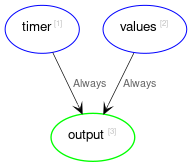

In [25]:
g = StreamGraph()

# Create source nodes
timer = source!(g, :timer, out=DateTime, init=DateTime(0))
values = source!(g, :values, out=Float64, init=0.0)

# Create sink nodes
output = sink!(g, :output, Func((exe; values, timer) -> println("output at time $(time(exe)): timer=$timer values=$values")), bind_as=NamedParams())
# output = sink!(g, :output, Func((exe; values, timer) -> 1+1), bind_as=NamedParams())

# Create edges between nodes (define the computation graph)
bind!(g, timer, output, call_policies=[Always()])
bind!(g, values, output, call_policies=[Always()])

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1, 0, 0, 0)
stop = DateTime(2000, 1, 1, 0, 0, 59)
# stop = DateTime(2030, 1, 2, 0, 0, 0)
adapters = [
    TimerAdapter{DateTime}(exe, timer; interval=Dates.Second(5), start_time=start),
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1, 0, 0, 1), 1.0),
        (DateTime(2000, 1, 1, 0, 0, 2), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 7), 7.0),
        (DateTime(2000, 1, 1, 0, 0, 10), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 15), 15.0),
        (DateTime(2000, 1, 1, 0, 0, 16), 16.0),
    ]),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

# adapter = adapters[1]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, adapter.current_time)
# @code_native adapter.adapter_func(exe, adapter.current_time)

# adapter = adapters[2]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, adapter.current_time)
# @code_native adapter.adapter_func(exe, 1.0)

Multi-input PositionParams

In [ ]:
g = StreamGraph()

# Create source nodes
timer = source!(g, :timer, out=DateTime, init=DateTime(0))
values = source!(g, :values, out=Float64, init=0.0)

# Create sink nodes
output = sink!(g, :output, Func((exe, timer, values) -> println("output at time $(time(exe)): timer=$timer values=$values")), bind_as=PositionParams())
# output = sink!(g, :output, Func((exe, timer, values) -> 1+1), bind_as=PositionParams())

# Create edges between nodes (define the computation graph)
bind!(g, timer, output, call_policies=[Always()])
bind!(g, values, output, call_policies=[Always()])

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1, 0, 0, 0)
stop = DateTime(2000, 1, 1, 0, 0, 59)
# stop = DateTime(2030, 1, 2, 0, 0, 0)
adapters = [
    TimerAdapter{DateTime}(exe, timer; interval=Dates.Second(5), start_time=start),
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1, 0, 0, 1), 1.0),
        (DateTime(2000, 1, 1, 0, 0, 2), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 7), 7.0),
        (DateTime(2000, 1, 1, 0, 0, 10), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 15), 15.0),
        (DateTime(2000, 1, 1, 0, 0, 16), 16.0),
    ]),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

# adapter = adapters[1]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, adapter.current_time)
# @code_native adapter.adapter_func(exe, adapter.current_time)

# adapter = adapters[2]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native run_simulation!(exe, adapters; start_time=start, end_time=stop)
# @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, 1.0)
# # @code_native adapter.adapter_func(exe, 1.0)

Multi-input TupleParams

output at time 2000-01-01T00:00:00: timer=2000-01-01T00:00:00 values=0.0
output at time 2000-01-01T00:00:01: timer=2000-01-01T00:00:00 values=1.0
output at time 2000-01-01T00:00:02: timer=2000-01-01T00:00:00 values=2.0
output at time 2000-01-01T00:00:04: timer=2000-01-01T00:00:00 values=4.0
output at time 2000-01-01T00:00:05: timer=2000-01-01T00:00:05 values=4.0
output at time 2000-01-01T00:00:07: timer=2000-01-01T00:00:05 values=7.0
output at time 2000-01-01T00:00:10: timer=2000-01-01T00:00:10 values=7.0
output at time 2000-01-01T00:00:10: timer=2000-01-01T00:00:10 values=10.0
output at time 2000-01-01T00:00:15: timer=2000-01-01T00:00:15 values=10.0
output at time 2000-01-01T00:00:15: timer=2000-01-01T00:00:15 values=15.0
output at time 2000-01-01T00:00:16: timer=2000-01-01T00:00:15 values=16.0
output at time 2000-01-01T00:00:20: timer=2000-01-01T00:00:20 values=16.0
output at time 2000-01-01T00:00:25: timer=2000-01-01T00:00:25 values=16.0
output at time 2000-01-01T00:00:30: timer=200

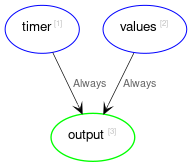

In [27]:
g = StreamGraph()

# Create source nodes
timer = source!(g, :timer, out=DateTime, init=DateTime(0))
values = source!(g, :values, out=Float64, init=0.0)

# Create sink nodes
output = sink!(g, :output, Func((exe, params) -> println("output at time $(time(exe)): timer=$(params[1]) values=$(params[2])")), bind_as=TupleParams())

# Create edges between nodes (define the computation graph)
bind!(g, timer, output, call_policies=[Always()])
bind!(g, values, output, call_policies=[Always()])

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1, 0, 0, 0)
stop = DateTime(2000, 1, 1, 0, 0, 59)
# stop = DateTime(2030, 1, 2, 0, 0, 0)
adapters = [
    TimerAdapter{DateTime}(exe, timer; interval=Dates.Second(5), start_time=start),
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1, 0, 0, 1), 1.0),
        (DateTime(2000, 1, 1, 0, 0, 2), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 7), 7.0),
        (DateTime(2000, 1, 1, 0, 0, 10), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 15), 15.0),
        (DateTime(2000, 1, 1, 0, 0, 16), 16.0),
    ]),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

# adapter = adapters[1]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, adapter.current_time)
# @code_native adapter.adapter_func(exe, adapter.current_time)

# adapter = adapters[2]
# # @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# # @code_native run_simulation!(exe, adapters; start_time=start, end_time=stop)
# @code_native advance!(adapter, exe)
# # @code_warntype adapter.adapter_func(exe, 1.0)
# # @code_native adapter.adapter_func(exe, 1.0)

Time-based bucket aggregation

output #1 at time 2000-01-01T00:00:00: Float64[]
output #1 at time 2000-01-03T00:00:00: [1.0, 2.0]
output #1 at time 2000-01-05T00:00:00: [3.0, 4.0]
  0.069169 seconds (182.96 k allocations: 12.256 MiB, 99.60% compilation time)


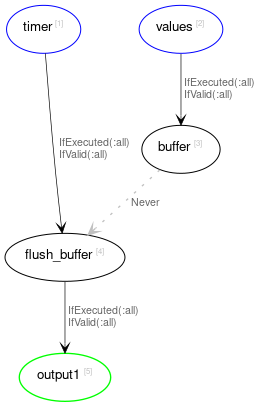

In [36]:
g = StreamGraph()

# Create source nodes
timer = source!(g, :timer, out=DateTime, init=DateTime(0))
values = source!(g, :values, out=Float64, init=0.0)

# Create operation nodes
buffer = op!(g, :buffer, Buffer{Float64}(), out=Buffer{Float64})
flush_buffer = op!(g, :flush_buffer, Func{Vector{Float64}}((exe, buf, dt) -> begin
    vals = copy(buf)
    empty!(buf)
    vals
end, Float64[]), out=Vector{Float64})

# Create sink nodes
output1 = sink!(g, :output1, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, values, buffer)
bind!(g, buffer, flush_buffer; call_policies=[Never()])
# bind!(g, timer, flush_buffer; call_policies=[IfSource(timer)])
bind!(g, timer, flush_buffer)
bind!(g, flush_buffer, output1)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 6)
adapters = [
    TimerAdapter{DateTime}(exe, timer; interval=Dates.Day(2), start_time=start),
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 3.0),
        (DateTime(2000, 1, 4), 4.0),
        (DateTime(2000, 1, 5), 5.0),
        (DateTime(2000, 1, 6), 6.0)
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Lag

In [ ]:
g = StreamGraph()

source_values = source!(g, :source_values, out=Float64, init=0.0)
lag = op!(g, :lag, Lag{Float64}(2), out=Float64)
output = sink!(g, :output, Func((exe, x) -> println("output at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, source_values, lag)
bind!(g, lag, output)

# test = sink!(g, :debug, Func((exe, x) -> println(is_valid(lag.operation))))
# bind!(g, lag, test, call_policy=Always())

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, source_values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 3.0),
        (DateTime(2000, 1, 4), 4.0),
        (DateTime(2000, 1, 5), 5.0),
        (DateTime(2000, 1, 6), 6.0),
        (DateTime(2000, 1, 7), 7.0),
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Difference

In [ ]:
g = StreamGraph()

values = source!(g, :values, out=Float64, init=0.0)
lag = op!(g, :lag, Lag{Float64}(2), out=Float64)
diff = op!(g, :diff, Func((exe, x, y) -> (time(exe), x - y), (DateTime(0), 0.0)), out=Tuple{DateTime,Float64})
output = sink!(g, :output, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, values, lag)
bind!(g, values, diff)
bind!(g, lag, diff)
bind!(g, diff, output)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 2.5),
        (DateTime(2000, 1, 4), 1.75),
        (DateTime(2000, 1, 5), 2.1),
        (DateTime(2000, 1, 6), 3.0),
        (DateTime(2000, 1, 7), 4.0),
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Rolling window

In [ ]:
g = StreamGraph()

values = source!(g, :values, out=Float64, init=0.0)
rolling = op!(g, :rolling, WindowBuffer{Float64}(3), out=AbstractVector{Float64})
output = sink!(g, :output, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, values, rolling)
bind!(g, rolling, output)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 2.5),
        (DateTime(2000, 1, 4), 1.75),
        (DateTime(2000, 1, 5), 2.1),
        (DateTime(2000, 1, 6), 3.0),
        (DateTime(2000, 1, 7), 4.0),
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Combine multiple sources

In [ ]:
g = StreamGraph()

values1 = source!(g, :values1, out=Float64, init=NaN)
values2 = source!(g, :values2, out=Float64, init=NaN)
values3 = source!(g, :values3, out=Float64, init=NaN)
values4 = source!(g, :values4, out=Float64, init=NaN)
combine = op!(g, :combine, Func{NTuple{4,Any}}((exe, x1, x2, x3, x4) -> tuple(x1, x2, x3, x4), ntuple(x -> 0.0, 4)), out=NTuple{4,Any})
output = sink!(g, :output, Func((exe, x) -> println("output at time $(time(exe)): $x")))

bind!(g, (values1, values2, values3, values4), combine, call_policies=[IfExecuted(:any)])
# bind!(g, (values1, values2, values3, values4), combine, call_policies=[IfExecuted(values1, values2)])
bind!(g, combine, output)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(1999, 12, 31)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, values1, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 3.0),
        (DateTime(2000, 1, 4), 4.0),
        (DateTime(2000, 1, 5), 5.0),
        (DateTime(2000, 1, 6), 6.0),
        (DateTime(2000, 1, 7), 7.0),
    ]),
    IterableAdapter(exe, values2, [
        (DateTime(2000, 1, 2), 20.0),
        (DateTime(2000, 1, 4), 40.0),
        (DateTime(2000, 1, 6), 60.0),
        (DateTime(2000, 1, 8), 80.0),
    ]),
    IterableAdapter(exe, values3, [
        (DateTime(1999, 12, 31), 1000.0),
    ]),
    IterableAdapter(exe, values4, []) # empty
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Features generation

In [ ]:
g = StreamGraph()

values = source!(g, :values, out=Float64, init=0.0)

value = op!(g, :value, Func{Float64}((exe, v) -> v, 0.0), out=Float64)
lag1 = op!(g, :lag_1, Lag{Float64}(1), out=Float64)
lag2 = op!(g, :lag_2, Lag{Float64}(2), out=Float64)
diff_1 = op!(g, :diff_1, Func{Float64}((exe, value, lagged) -> value - lagged, 0.0), out=Float64)
combine = op!(g, :combine, Func{NTuple{4,Float64}}((exe, args...) -> tuple(args...), ntuple(x -> 0.0, 4)), out=NTuple{4,Float64})
dates = DateTime[]
records = NTuple{4,Any}[]
output = sink!(g, :output, Func((exe, x) -> println("output at time $(time(exe)): $x")))
collector = sink!(g, :collector, Func((exe, x) -> begin
    push!(dates, time(exe))
    push!(records, x)
    nothing
end))

bind!(g, values, value, call_policies=[Always()])
bind!(g, values, lag1, call_policies=[Always()])
bind!(g, values, lag2, call_policies=[Always()])
bind!(g, values, diff_1, call_policies=[Always()])
bind!(g, lag1, diff_1, call_policies=[Always()])
bind!(g, (value, lag1, lag2, diff_1), combine, call_policies=[Always()])
bind!(g, combine, output, call_policies=[Always()])
bind!(g, combine, collector, call_policies=[Always()])

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2020, 1, 1, 0, 0, 0)
stop = DateTime(2020, 1, 1, 0, 0, 40)
adapters = [
    IterableAdapter(exe, values, [(DateTime(2020, 1, 1, 0, 0, i), Float64(i * 100)) for i in 1:3:40]),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)

display(dates)
display(records)

graphviz(exe.graph)

1 source, 1 output incl. Counter

In [ ]:
g = StreamGraph()

# Create source nodes
source_timer = source!(g, :source_timer, out=DateTime, init=DateTime(0))

# Create sink nodes
output = sink!(g, :output, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))
# output = sink!(g, :output, Func((exe, x) -> nothing))
counter = sink!(g, :counter, Counter())

# Create edges between nodes (define the computation graph)
bind!(g, source_timer, output)
bind!(g, source_timer, counter)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1, 0, 0, 0)
stop = DateTime(2000, 1, 1, 0, 0, 59)
# stop = DateTime(2030, 1, 2, 0, 0, 0)
adapters = [
    TimerAdapter{DateTime}(exe, source_timer; interval=Dates.Second(5), start_time=start),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
println("Counter: ", get_state(counter.operation))
graphviz(exe.graph)

In [ ]:
info(exe.states)

In [ ]:
dump(exe.states)

In [ ]:
# using BenchmarkTools
# adapter = adapters[1]
# @benchmark begin
#     adapter.current_time = start
#     run_simulation!(exe, adapters; start_time=start, end_time=stop)
# end evals=1 samples=30

In [ ]:
# using ProfileView
# adapter = adapters[1]
# ProfileView.@profview begin
#     adapter.current_time = DateTime(2000, 1, 1, 0, 0, 0)
#     run_simulation!(exe, adapters; start_time=start, end_time=stop)
# end 

In [ ]:
# adapter = adapters[1]
# @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# @code_native advance!(adapter, exe)
# @code_warntype adapter.adapter_func(exe, adapter.current_time)

First demo graph

In [ ]:
g = StreamGraph()

# Create source nodes
source1 = source!(g, :source1, out=Float64, init=NaN)
source2 = source!(g, :source2, out=Float64, init=NaN)
source3 = source!(g, :source3, out=Float64, init=NaN)

# Create compute nodes
square = op!(g, :square, Func{Float64}((exe, x) -> x^2, 0.0); out=Float64)
divide_by_2 = op!(g, :divide_by_2, Func{Float64}((exe, x) -> x / 2, 0.0); out=Float64)
negate = op!(g, :negate, Func{Float64}((exe, x) -> -x, 0.0); out=Float64)
combine = op!(g, :combine, Func{Tuple{Float64,Float64}}((exe, x, y) -> (x, y), (0.0, 0.0)); out=Tuple{Float64,Float64})
final_multiply = op!(g, :final_multiply, Func{Tuple{Float64,Float64}}((exe, tuple, src2, src3) -> tuple .* src2 .+ src3, (0.0, 0.0)); out=Tuple{Float64,Float64})

# Create sink nodes
output1 = sink!(g, :output1, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))
output2 = sink!(g, :output2, Func((exe, x) -> println("output #2 at time $(time(exe)): $x")))
# output2 = sink!(g, :output2, (exe, x) -> nothing)

# Create edges between nodes (define the computation graph)
bind!(g, source1, square)
bind!(g, square, divide_by_2)
bind!(g, source2, negate)
# bind!(g, divide_by_2, combine, call_policies=[IfValid()])
# bind!(g, negate, combine, call_policies=[IfValid()])
bind!(g, (divide_by_2, negate), combine, call_policies=[IfValid()])
# bind!(g, combine, final_multiply, call_policies=[IfValid()])
# bind!(g, source2, final_multiply, call_policies=[IfValid()])
# bind!(g, source3, final_multiply, call_policies=[IfValid()])
bind!(g, (combine, source2, source3), final_multiply, call_policies=[IfValid()])
bind!(g, final_multiply, output1)
bind!(g, combine, output2)

exe = compile_historic_executor(DateTime, g, debug=!true)

adapters = [
    IterableAdapter(exe, source1, [
        (DateTime(2000, 1, 1, 0, 0, 1), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 3), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 5), 6.0)
    ]),
    IterableAdapter(exe, source2, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ]),
    IterableAdapter(exe, source3, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ])
]
run_simulation!(exe, adapters; start_time=DateTime(2000, 1, 1, 0, 0, 1), end_time=DateTime(2000, 1, 1, 0, 0, 6))

graphviz(exe.graph)

Realtime

In [ ]:
g = StreamGraph()

timer = source!(g, :timer, out=DateTime, init=DateTime(0))
output = sink!(g, :output, Func((exe, x) -> println("output at time $(time(exe)): $x")))
bind!(g, timer, output, call_policies=[Always()])

display(graphviz(g))

exe = compile_realtime_executor(DateTime, g; debug=!true)

start = now()
stop = now() + Dates.Second(1)
adapters = [
    LiveTimerAdapter{DateTime}(exe, timer; interval=Dates.Millisecond(200), start_time=start),
]
println("number of threads: $(Threads.nthreads())")
@time run_realtime!(exe, adapters; start_time=start, end_time=stop)

# Base.exit_on_sigint(true)